In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve

In [2]:
torch.manual_seed(42)
np.random.seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, bottleneck_dim=32):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, bottleneck_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, bottleneck_dim=32, hidden_dim=128, output_dim=784):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.fc1 = nn.Linear(bottleneck_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = x.view(-1, 1, 28, 28)
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, bottleneck_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, bottleneck_dim)
        self.decoder = Decoder(bottleneck_dim, hidden_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
normal_digit = 3
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

normal_indices = torch.where(torch.tensor(train_dataset.targets) == normal_digit)[0]
normal_train_dataset = Subset(train_dataset, normal_indices)

train_loader = DataLoader(normal_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of normal training samples (digit {normal_digit}): {len(normal_train_dataset)}")
print(f"Number of test samples (all digits): {len(test_dataset)}")


Number of normal training samples (digit 3): 6131
Number of test samples (all digits): 10000


/tmp/ipykernel_268370/1806637769.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normal_indices = torch.where(torch.tensor(train_dataset.targets) == normal_digit)[0]


In [4]:
def compute_reconstruction_error(model, dataloader, device):
    model.eval()
    reconstruction_errors = []
    labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            output = model(data)

            # Compute the mean squared error
            error = F.mse_loss(output, data, reduction='none')
            error = error.view(data.size(0), -1).mean(dim=1)  

            reconstruction_errors.extend(error.cpu().numpy())
            labels.extend(target.numpy())

    return np.array(reconstruction_errors), np.array(labels)



def plot_error_histogram(errors, labels, normal_digit=3,):
    normal_errors = errors[labels == normal_digit]
    anomaly_errors = errors[labels != normal_digit]

    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.7, label=f'Normal (Digit {normal_digit})', color='green', density=True)
    plt.hist(anomaly_errors, bins=50, alpha=0.7, label='Anomaly (Other Digits)', color='red', density=True)
    plt.axvline(x=np.percentile(normal_errors, 95), color='blue', linestyle='--',
                label='95th Percentile (Possible Threshold)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return np.percentile(normal_errors, 95)


def evaluate_model(errors, labels, threshold, normal_digit=3):
    y_true = (labels != normal_digit).astype(int)
    y_pred = (errors > threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    print(f"Performance metrics with threshold {threshold:.6f}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return precision, recall, f1


def plot_roc_curve(errors_list, labels_list, bottleneck_dims, normal_digit=3, save_path=None):
    plt.figure(figsize=(10, 8))

    for i, (errors, labels, dim) in enumerate(zip(errors_list, labels_list, bottleneck_dims)):
        y_true = (labels != normal_digit).astype(int)
        fpr, tpr, _ = roc_curve(y_true, errors)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'Bottleneck dim={dim} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Bottleneck Dimensions')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
    plt.show()


In [5]:
bottleneck_dims = [8, 32, 64, 100]
epochs = 100
learning_rate = 0.003




Training model with bottleneck dimension: 8
Epoch 1/100, Loss: 0.060825
Epoch 10/100, Loss: 0.019303
Epoch 20/100, Loss: 0.017108
Epoch 30/100, Loss: 0.016272
Epoch 40/100, Loss: 0.015810
Epoch 50/100, Loss: 0.015417
Epoch 60/100, Loss: 0.015141
Epoch 70/100, Loss: 0.014889
Epoch 80/100, Loss: 0.014725
Epoch 90/100, Loss: 0.014570
Epoch 100/100, Loss: 0.014457
Training complete!
Computing reconstruction errors...


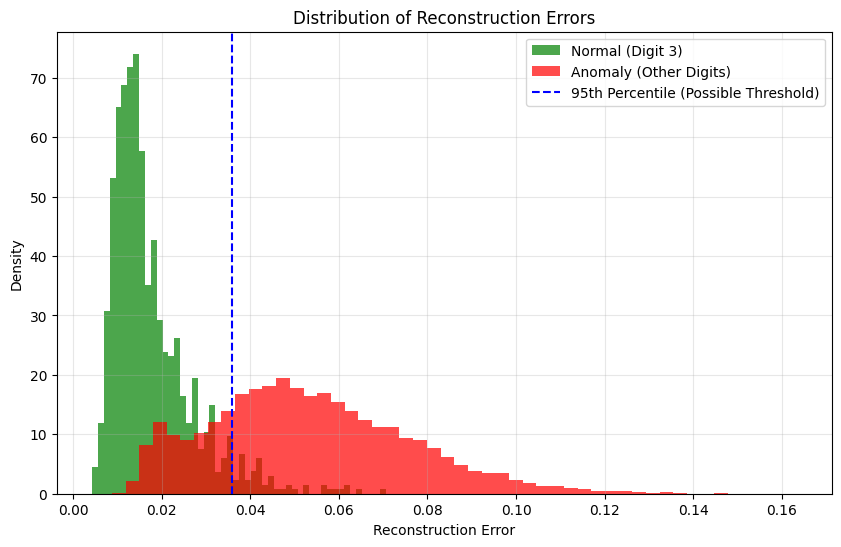


Evaluating model performance with suggested threshold:
Performance metrics with threshold 0.035957:
Precision: 0.9927
Recall: 0.7683
F1 Score: 0.8662






Training model with bottleneck dimension: 32
Epoch 1/100, Loss: 0.060746
Epoch 10/100, Loss: 0.010151
Epoch 20/100, Loss: 0.007164
Epoch 30/100, Loss: 0.006009
Epoch 40/100, Loss: 0.005433
Epoch 50/100, Loss: 0.005090
Epoch 60/100, Loss: 0.004891
Epoch 70/100, Loss: 0.004782
Epoch 80/100, Loss: 0.004624
Epoch 90/100, Loss: 0.004551
Epoch 100/100, Loss: 0.004528
Training complete!
Computing reconstruction errors...


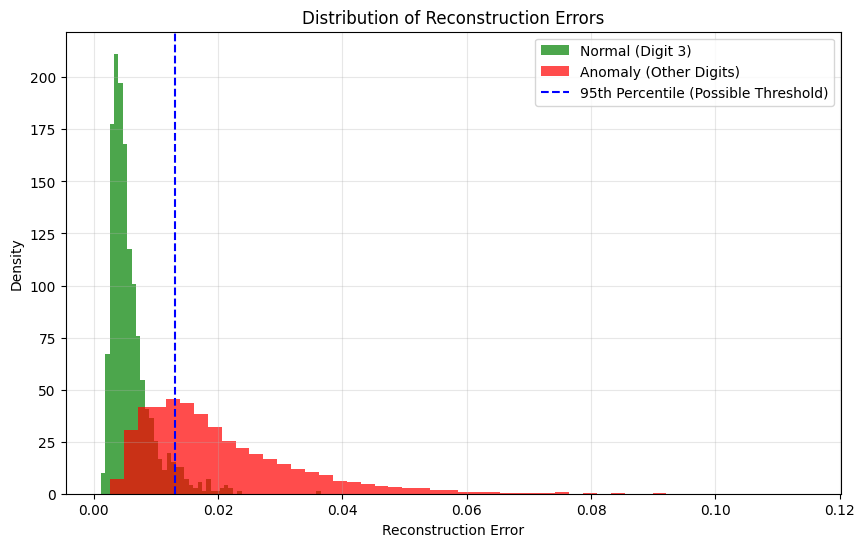


Evaluating model performance with suggested threshold:
Performance metrics with threshold 0.012990:
Precision: 0.9916
Recall: 0.6664
F1 Score: 0.7971






Training model with bottleneck dimension: 64
Epoch 1/100, Loss: 0.060757
Epoch 10/100, Loss: 0.009356
Epoch 20/100, Loss: 0.006234
Epoch 30/100, Loss: 0.004926
Epoch 40/100, Loss: 0.004223
Epoch 50/100, Loss: 0.003812
Epoch 60/100, Loss: 0.003493
Epoch 70/100, Loss: 0.003300
Epoch 80/100, Loss: 0.003105
Epoch 90/100, Loss: 0.002954
Epoch 100/100, Loss: 0.002854
Training complete!
Computing reconstruction errors...


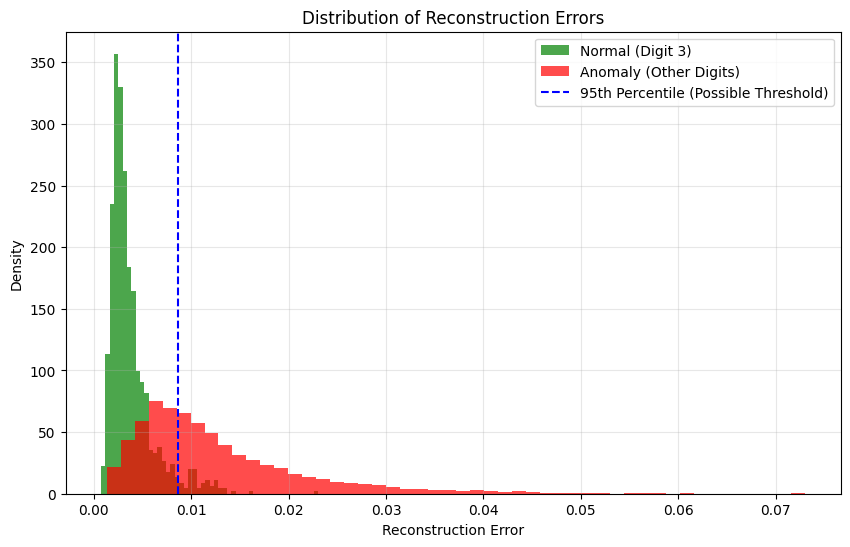


Evaluating model performance with suggested threshold:
Performance metrics with threshold 0.008642:
Precision: 0.9907
Recall: 0.6042
F1 Score: 0.7506






Training model with bottleneck dimension: 100
Epoch 1/100, Loss: 0.058372
Epoch 10/100, Loss: 0.008651
Epoch 20/100, Loss: 0.005580
Epoch 30/100, Loss: 0.004441
Epoch 40/100, Loss: 0.003837
Epoch 50/100, Loss: 0.003436
Epoch 60/100, Loss: 0.003057
Epoch 70/100, Loss: 0.002946
Epoch 80/100, Loss: 0.002720
Epoch 90/100, Loss: 0.002566
Epoch 100/100, Loss: 0.002483
Training complete!
Computing reconstruction errors...


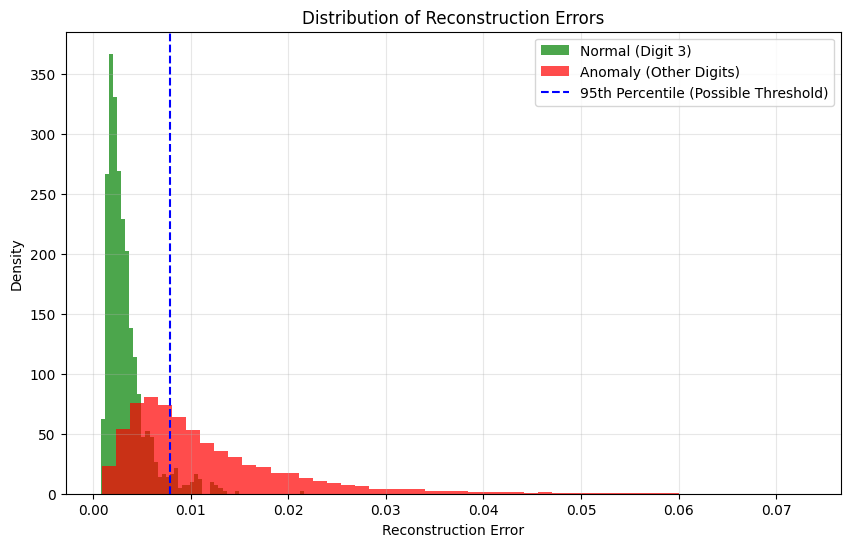


Evaluating model performance with suggested threshold:
Performance metrics with threshold 0.007924:
Precision: 0.9901
Recall: 0.5676
F1 Score: 0.7216






In [6]:
all_errors = []
all_labels = []

for bottleneck_dim in bottleneck_dims:
    print(f"\n")
    print(f"Training model with bottleneck dimension: {bottleneck_dim}")

    model = Autoencoder(bottleneck_dim=bottleneck_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        train_loss = train_loss / len(normal_train_dataset)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.6f}")

    print("Training complete!")

    print("Computing reconstruction errors...")
    errors, labels = compute_reconstruction_error(model, test_loader, device)
    all_errors.append(errors)
    all_labels.append(labels)


    suggested_threshold = plot_error_histogram(errors, labels, normal_digit=normal_digit)

    print("\nEvaluating model performance with suggested threshold:")
    evaluate_model(errors, labels, suggested_threshold, normal_digit=normal_digit)
    print(f"\n")
    print(f"\n")



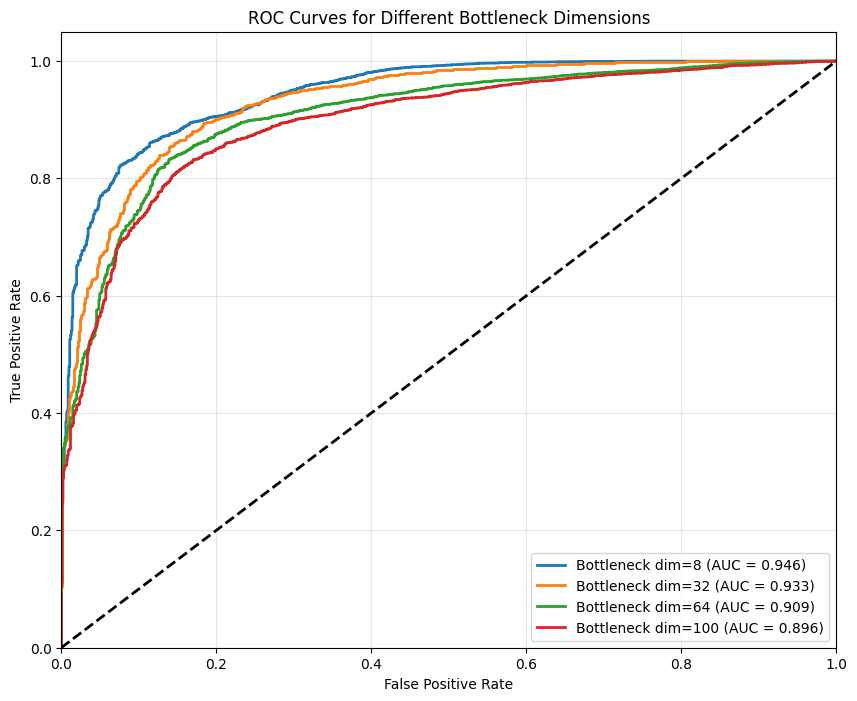


AUC-ROC Scores:
Bottleneck dimension 8: AUC-ROC = 0.9464
Bottleneck dimension 32: AUC-ROC = 0.9326
Bottleneck dimension 64: AUC-ROC = 0.9086
Bottleneck dimension 100: AUC-ROC = 0.8964


In [7]:
plot_roc_curve(
    all_errors, all_labels, bottleneck_dims,
    normal_digit=normal_digit,
    save_path='roc_curves_comparison.png'
)

print("\nAUC-ROC Scores:")
for i, (errors, labels, dim) in enumerate(zip(all_errors, all_labels, bottleneck_dims)):
    y_true = (labels != normal_digit).astype(int)
    roc_auc = auc(*roc_curve(y_true, errors)[:2])
    print(f"Bottleneck dimension {dim}: AUC-ROC = {roc_auc:.4f}")

### **Observations from AUC-ROC Scores and Plot**

1. **Higher AUC Indicates Better Anomaly Detection**  
   - The **bottleneck dimension of 8** achieves the highest AUC-ROC score (0.946), meaning it has the best trade-off between true positive rate and false positive rate.  

2. **Effect of Bottleneck Dimension on Performance**  
   - As the bottleneck dimension increases, the AUC-ROC decreases.  
   - This suggests that a **more compact latent space** (lower bottleneck dimension) retains essential features while removing noise, leading to better anomaly detection.  

3. **Overfitting in Higher Bottleneck Dimensions**  
   - A larger bottleneck (e.g., **100**) results in a **lower AUC-ROC (0.896)**, likely because the model reconstructs both normal and anomalous digits well, making it harder to distinguish anomalies.  

4. **Optimal Bottleneck Size**  
   - The **bottleneck dimension of 8 or 32** seems optimal, balancing representation and generalization for anomaly detection.  
   - Too small a bottleneck might lose crucial information, while too large a bottleneck might allow the model to reconstruct anomalies too well.  
